In [1]:
import sys
sys.path.insert(0,'../..')
import numpy as np
import matplotlib.pyplot as plt
import rivapy

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Nelson-Siegel Parametrization

$f(t) = \beta_0 + (\beta_1+\beta_2)\frac{1-e^{-t/\tau}}{t/\tau} -\beta_2e^{t/\tau}$

where 
- $\beta_0$ determines is the asymptotic (for arbitrary large maturities) rate.
- $\beta_1$ determines via $\beta_0 + \beta_1$ the short term rate.
- $\beta_2$ controls the size of the hump.
- $\tau$ controls the location of the hump.

In [2]:
from rivapy.marketdata import NelsonSiegel, NelsonSiegelSvensson, DiscountCurveParametrized

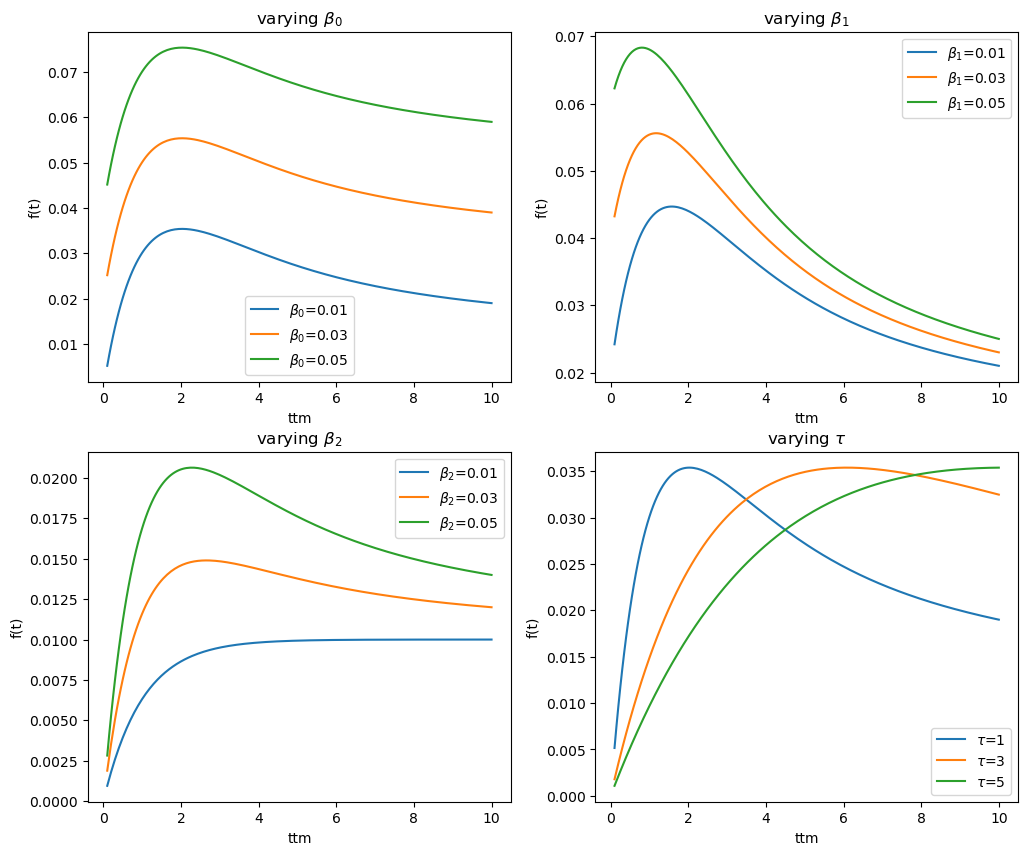

In [3]:
plt.figure(figsize=(12,10))
t = np.linspace(0.1,10.0, 200)
beta0 = 0.01
shortterm_rate = 0.02
beta2 = 0.1
beta1 = -0.01
tau=1.0
plt.subplot(2,2,1)
for b in [0.01, 0.03, 0.05]:
    nelson_siegel = NelsonSiegel(b, beta1, beta2, tau)
    plt.plot(t, nelson_siegel(t), label='$\\beta_0$='+ str(b))
plt.xlabel('ttm')
plt.ylabel('f(t)')
plt.title('varying $\\beta_0$')
plt.legend()
plt.subplot(2,2,2)
for b in [0.01, 0.03, 0.05]:
    nelson_siegel = NelsonSiegel(beta0, b, beta2, tau)
    plt.plot(t, nelson_siegel(t), label='$\\beta_1$='+ str(b))
plt.xlabel('ttm')
plt.ylabel('f(t)')
plt.title('varying $\\beta_1$')
plt.legend()
plt.subplot(2,2,3)
for b in [0.01, 0.03, 0.05]:
    nelson_siegel = NelsonSiegel(beta0, beta1, b, tau)
    plt.plot(t, nelson_siegel(t), label='$\\beta_2$='+ str(b))
plt.xlabel('ttm')
plt.ylabel('f(t)')
plt.title('varying $\\beta_2$')
plt.legend()
plt.subplot(2,2,4)
for ta in [1,3,5]:#[0.01, 0.03, 0.05]:
    nelson_siegel = NelsonSiegel(beta0, beta1, beta2, ta)
    plt.plot(t, nelson_siegel(t), label='$\\tau$='+ str(ta))
plt.xlabel('ttm')
plt.ylabel('f(t)')
plt.title('varying $\\tau$')
plt.legend()
plt.show()

# Nelson-Siegel-Svensson Parametrization

$f(t) = \beta_0 + (\beta_1+\beta_2)\frac{1-e^{-t/\tau}}{t/\tau} -\beta_2e^{t/\tau} + \beta_3\left(\frac{1-e^{-t/ {\tau_2}}}{t/{\tau}_2} -e^{-t/\tau_2} \right) $

where 
- $\beta_0$ determines is the asymptotic (for arbitrary large maturities) rate.
- $\beta_1$ determines via $\beta_0 + \beta_1$ the short term rate.
- $\beta_2$ controls the size of the hump.
- $\tau$ controls the location of the hump.

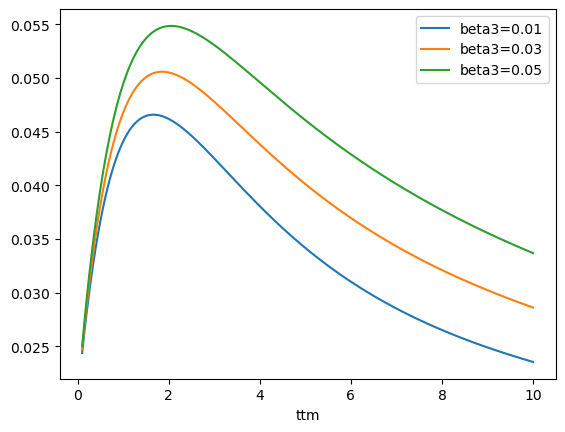

In [4]:
beta0 = 0.01
shortterm_rate = 0.02
beta2 = 0.1
beta3 = 10.0
tau=1.0
tau2 = 3.0
for beta3 in [0.01, 0.03, 0.05]:
    beta1 = shortterm_rate-beta0
    nelson_siegel_svensson = NelsonSiegelSvensson(beta0, beta1, beta2, beta3, tau, tau2)
    plt.plot(t, nelson_siegel_svensson(t), label='beta3='+ str(beta3))
plt.xlabel('ttm')
plt.legend()
plt.show()

# Spreadcurve Sampling

In [5]:
import datetime as dt
from rivapy.tools.enums import Rating, ESGRating
from rivapy.sample_data.market_data.spread_curves import RatingDependentCurve, CategoryDependentCurve

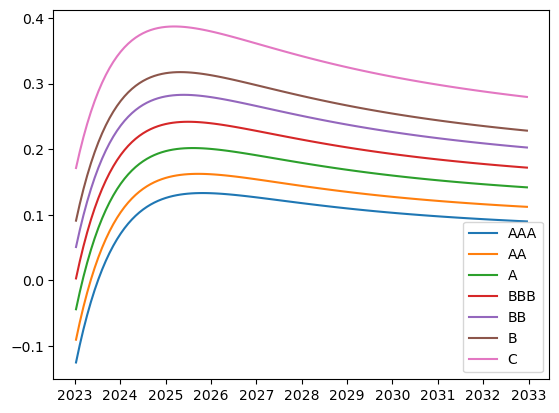

In [6]:
curve_high_rating = DiscountCurveParametrized('', dt.datetime(2023,1,1), 
                                              NelsonSiegel(beta0=0.05, beta1=-0.2, beta2=0.5, tau=1.0))
curve_offset = DiscountCurveParametrized('', dt.datetime(2023,1,1), 
                                              NelsonSiegel(beta0=0.15, beta1=0.2, beta2=0.0, tau=4.0))
weights = np.random.uniform(1.0,2.0, len(Rating))
weights = np.cumsum(weights)
weights /= weights[-1]
curve = RatingDependentCurve(curve_high_rating = curve_high_rating, 
                             curve_offset = curve_offset, curve_weights=weights)

dates = [curve_high_rating.refdate + dt.timedelta(days=i) for i in range(10,10*365,30)]

for r in ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C']:
    c = curve.get_curve(r)
    plt.plot(dates, [c.value_rate(dt.datetime(2023,1,1), d) for d in dates], label=r)
plt.legend()
plt.show()

In [29]:
curve_high_rating = DiscountCurveParametrized('', dt.datetime(2023,1,1), 
                                              NelsonSiegel(beta0=0.05, beta1=-0.2, beta2=0.5, tau=1.0))
curve_offset = DiscountCurveParametrized('', dt.datetime(2023,1,1), 
                                              NelsonSiegel(beta0=0.15, beta1=0.2, beta2=0.0, tau=4.0))
curve_low_ESG = DiscountCurveParametrized('', dt.datetime(2023,1,1), 
                                              NelsonSiegel(beta0=0.01, beta1=0.005, beta2=0.05, tau=2.0))
rating_weights = np.random.uniform(1.0,2.0, len(Rating))
rating_weights = np.cumsum(rating_weights)
rating_weights /= rating_weights[-1]
esg_curves = [RatingDependentCurve(curve_high_rating = curve_high_rating, 
                             curve_offset = curve_offset, curve_weights=rating_weights),
              RatingDependentCurve(curve_high_rating = curve_high_rating+curve_low_ESG, 
                             curve_offset = curve_offset+curve_low_ESG, curve_weights=rating_weights)
             ]
weights = np.array([[1.0,0.0],
                    [0.5,0.5],
                    [0.0,1.0],
                    [0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5]])

esg_curves = CategoryDependentCurve(esg_curves, weights=weights, categories=[r.value for r in ESGRating])

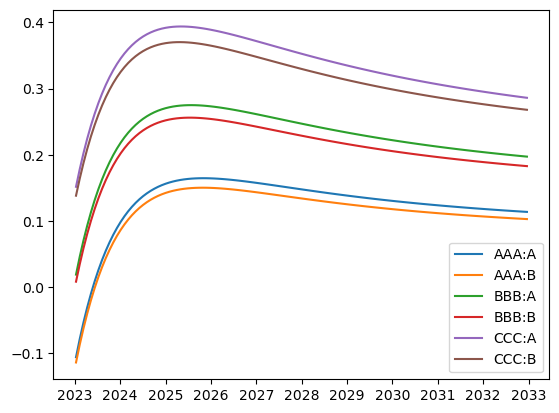

In [31]:
for r in ['AAA', 'BBB',  'CCC']:
    for esg_r in ['A', 'B']:
        c = esg_curves.get_curve(r, esg_r)
        plt.plot(dates, [c.value_rate(dt.datetime(2023,1,1), d) for d in dates], label=r+':'+esg_r)
plt.legend()
plt.show()